#  Прогнозирование заказов такси

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
%matplotlib inline

In [2]:
RANDOM_STATE = 12345
TSCV = TimeSeriesSplit(n_splits=3)

In [3]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Мы провели подготовку данных: распарсили, задали столбец-индекс и ресэмплировали данные с градацией по часу. Это поможет нам в последующем анализе.

## Анализ

Построим график временного ряда.

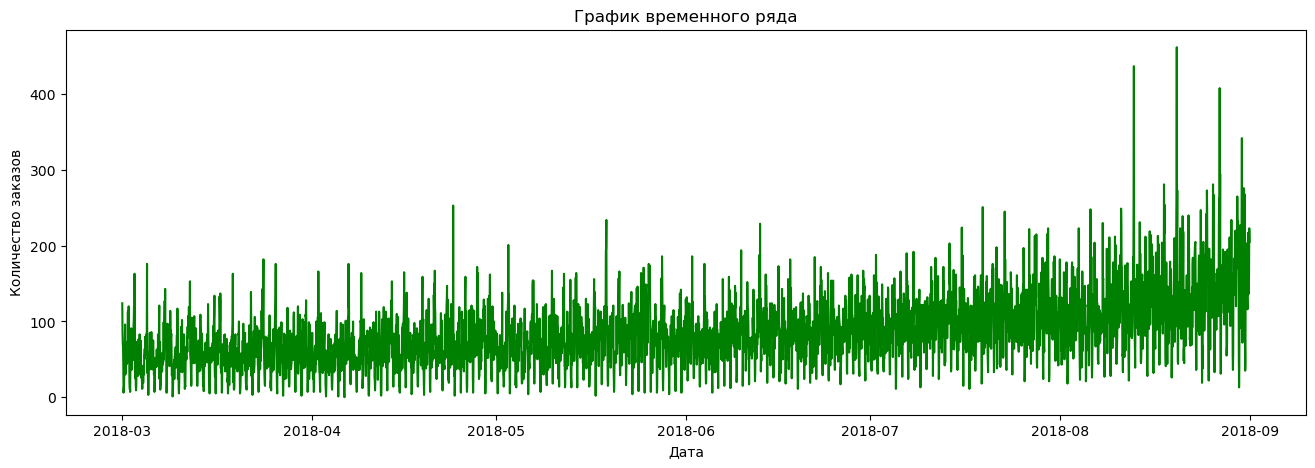

In [9]:
plt.figure(figsize=(16,5))
plt.title('График временного ряда')
plt.plot(data, color='green')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

По графику виден рост заказов по мере продвижения по временному ряду.

Проверим данные на тренд.

In [10]:
decomposed = seasonal_decompose(data)

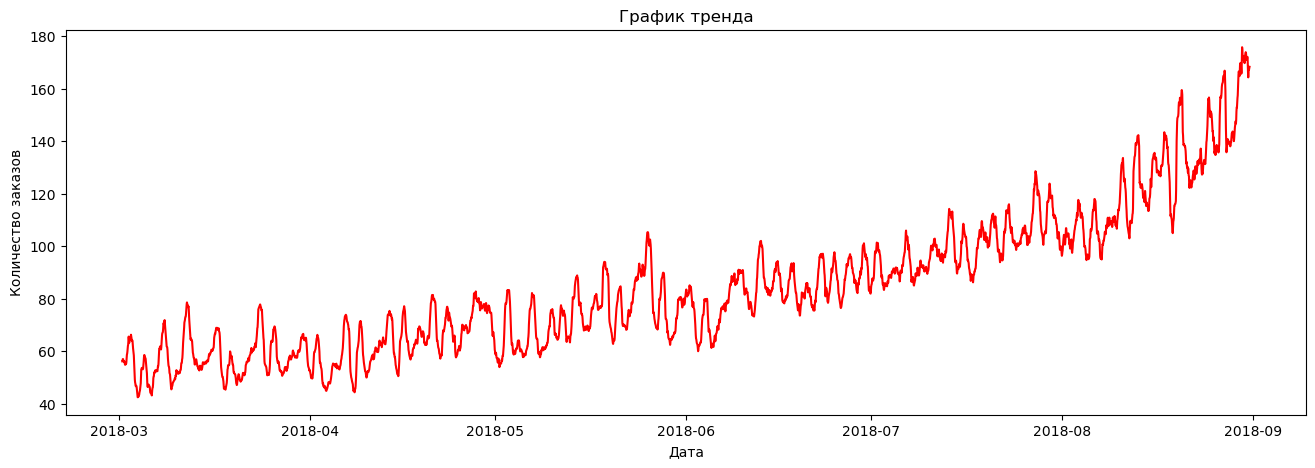

In [11]:
plt.figure(figsize=(16,5))
plt.title('График тренда')
plt.plot(decomposed.trend, color='red')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

По графику виден восходящий тренд. Проверим данные на сезонность.

Предположим, что люди чаще будут покупать билеты на будни дни, а не тратить выходные на отпуск. Проверим данные на сезонность(день, неделя).

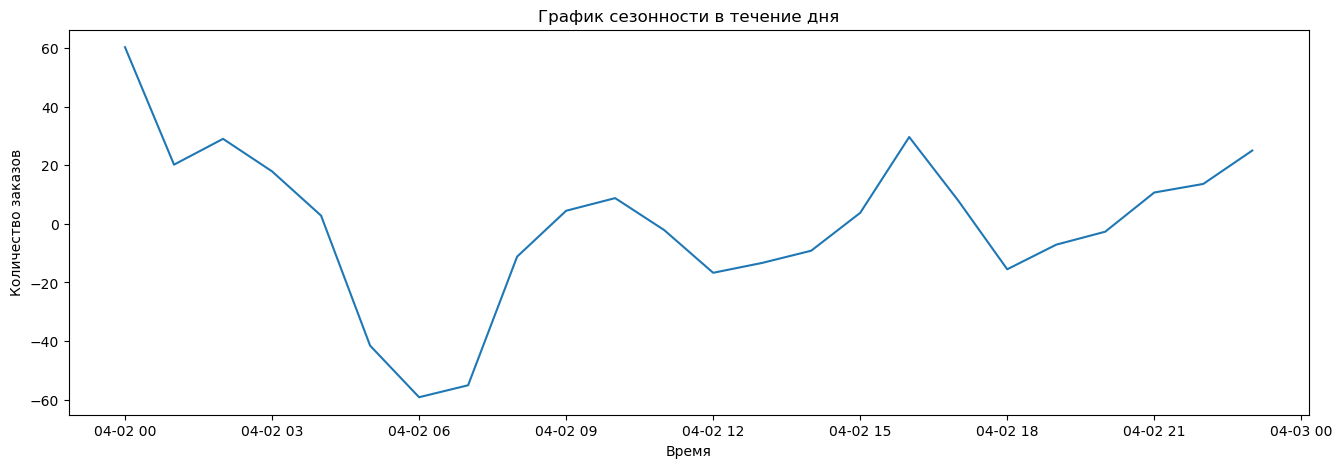

In [12]:
plt.figure(figsize=(16,5))
plt.title('График сезонности в течение дня')
plt.plot(decomposed.seasonal['2018-04-02':'2018-04-02'])
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

Заметны рост и падения в утренние и дневные часы с 6:00 до 15:00. В вечерние часы тоже есть некоторый рост заказов, однако наблюдается резкое падение после 2:00.

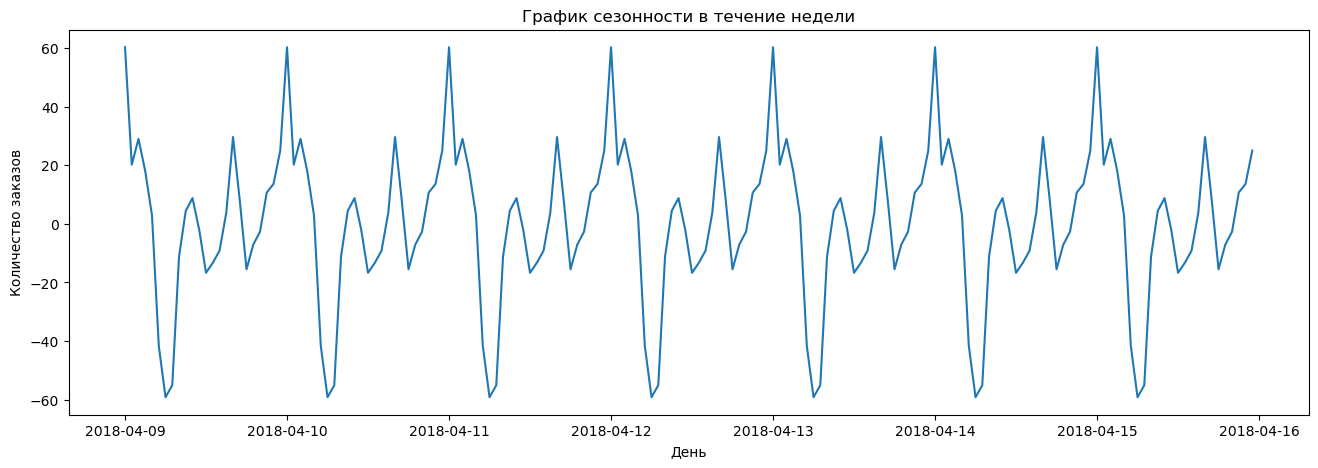

In [13]:
plt.figure(figsize=(16,5))
plt.title('График сезонности в течение недели')
plt.plot(decomposed.seasonal['2018-04-09':'2018-04-15'])
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

График выглядит циклично, значит можно предположить, что день не влияет на количество заказов.

Посмотрим на сезонность в течение месяца.

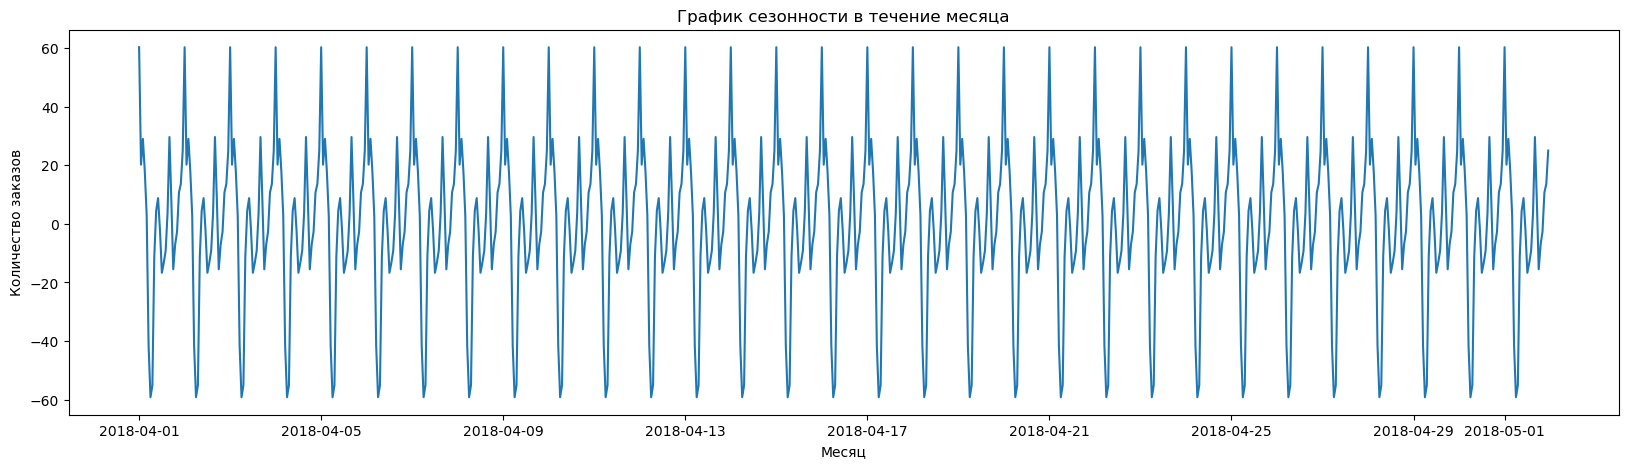

In [14]:
plt.figure(figsize=(20,5))
plt.title('График сезонности в течение месяца')
plt.plot(decomposed.seasonal['2018-04-01':'2018-05-01'])
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

По графику заметна аналогичная цикличность. Можем сделать вывод что природа цикличности – дневная.

Построим график остатков, чтобы проверить данные на стационарность. Сравним его с график всего временного ряда.

C:\Users\eesht\AppData\Local\Temp\ipykernel_7748\2194256266.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


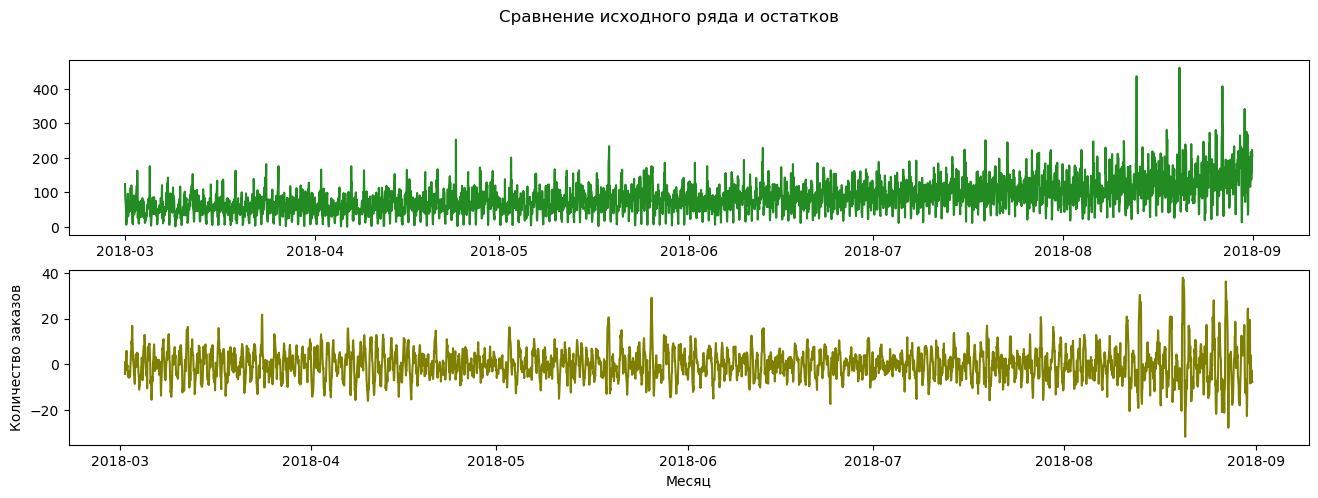

In [15]:
fig, axs = plt.subplots(2, figsize=(16, 5))
fig.suptitle('Сравнение исходного ряда и остатков')
axs[0].plot(data, color='forestgreen')
axs[1].plot(decomposed.resid.rolling(10).mean(), color='olive')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
fig.show()

По графику видно, что остатки практически совпадают с исходным временным рядом, однако ближе к концу ряда видны всплески. Проведем тест Дики-Фуллера и сделаем вывод о стационарности ряда.
Нулевая гипотеза: временной ряд не стационарен.

In [16]:
ad_result = adfuller(data, autolag='AIC')
print('Критерий ADF: %f' % ad_result[0])
print('P-значение: %f' % ad_result[1])

print('Критические значения:')

for key, value in ad_result[4].items():
    print('\t%s: %.3f' % (key, value))
if ad_result[0] < ad_result[4]["5%"] and ad_result[0] < ad_result[4]["1%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза не отвергнута – Временной ряд не стационарен


На основании теста и графика делаем вывод, что наш ряд не стационарен.

In [17]:
def drop(df):
    df_drop = df.copy()
    return df_drop.dropna()

In [18]:
data_new = drop(data)

Создадим новые признаки.

In [19]:
def make_features(d, max_lag, rolling_mean_size):
    d['day'] = d.index.day
    d['dayofweek'] = d.index.dayofweek
    d['weekday'] = d.index.weekday
    d['hour'] = d.index.hour
    d['is_weekend'] = d.weekday.isin([5, 6])
    d['is_morning'] = d.hour.isin(range(6, 15))
    
    for lag in range(1, max_lag + 1):
        d['lag_{}'.format(lag)] = d['num_orders'].shift(lag)

    d['rolling_mean'] = d['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    d = d.dropna()
    
    features = d.drop('num_orders', axis=1)
    target = d['num_orders']
    
    features_train, features_test, target_train, target_test = \
    train_test_split(features, target, shuffle=False, test_size=0.2)
    
    return features_train, features_test, target_train, target_test

In [20]:
features_train, features_test, target_train, target_test = \
make_features(data_new, 24, 24)

Мы провели анализ данных и пришли к выводу, что присутствуют: тренд и сезонность, а ряд стационарный. Были выделены нужные признаки и проведена подготовка данных к началу работы с моделями.

## Обучение

Обучим линейную регрессию, градиентный бустинг и CatBoostRegressor. Выберем наилучшую модель по метрике RMSE.

In [21]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

In [22]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
cv_lr = cross_val_score(model_lr, features_train, target_train, cv=TSCV, scoring = scorer)

In [23]:
print("Кросс-валидация линейной регрессии на обучающей выборке:", abs(cv_lr.mean()))

Кросс-валидация линейной регрессии на обучающей выборке: 26.161373193885836


In [24]:
model_gb = GradientBoostingRegressor(random_state=RANDOM_STATE)
model_gb.fit(features_train, target_train)
cv_gb = cross_val_score(model_gb, features_train, target_train, cv=TSCV, scoring = scorer)

In [25]:
print("Кросс-валидация градиентного бустинга на обучающей выборке:", abs(cv_gb.mean()))

Кросс-валидация градиентного бустинга на обучающей выборке: 24.473374797081885


In [26]:
params = {
    'iterations' : [500, 2000],
    'depth' : [4, 8]
}

model_cat = CatBoostRegressor(random_state=RANDOM_STATE, 
                              silent = True, loss_function = 'RMSE')



search_cat = GridSearchCV(estimator=model_cat,
                        param_grid=params, cv=TSCV,
                        scoring=scorer, n_jobs=-1)

search_cat.fit(features_train, target_train)
model_final_cat = search_cat.best_estimator_
cat_best = search_cat.best_score_

print('Лучшие гиперпараметры:', search_cat.best_params_)
print("Кросс-валидация CatBoostRegressor на обучающей выборке:", abs(cat_best))

Лучшие гиперпараметры: {'depth': 4, 'iterations': 2000}
Кросс-валидация CatBoostRegressor на обучающей выборке: 23.677684922748778


In [27]:
summary = pd.DataFrame(
    {
        'Кросс-валидация' : [abs(cv_lr.mean()), abs(cv_gb.mean()), abs(cat_best.mean())],
    },
    index = ['Linear Regression', 'Gradient Boosting regressor', 'Cat Boost Regressor']
).sort_values(by='Кросс-валидация')

summary

,Кросс-валидация
Cat Boost Regressor,23.677685
Gradient Boosting regressor,24.473375
Linear Regression,26.161373


Лучше всего себя показала модель Cat Boost Regressor, поэтому протестируем ее на тестовой выборке.

## Тестирование

Проверим модели на тестовой выборке.

In [28]:
final_pred_cat = model_final_cat.predict(features_test)
final_cat_rmse = mean_squared_error(target_test, final_pred_cat) ** 0.5
print('RMSE Cat Boost Regressor на тестовой выборке', final_cat_rmse)

RMSE Cat Boost Regressor на тестовой выборке 41.2067271086339


Добавим константную модель и сравним ее результат с Cat Boost Regressor.

In [29]:
dum = DummyRegressor(strategy='mean')
dum.fit(features_train, target_train)
pred_d = dum.predict(features_test)
rmse_dum = mean_squared_error(target_test, pred_d) ** 0.5
print('RMSE константной модели', rmse_dum)

RMSE константной модели 74.49708642948944


Cat Boost Regressor справился намного лучше константной модели
и уложился в пороговое значение RMSE = 48.

C:\Users\eesht\AppData\Local\Temp\ipykernel_7748\3535332886.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


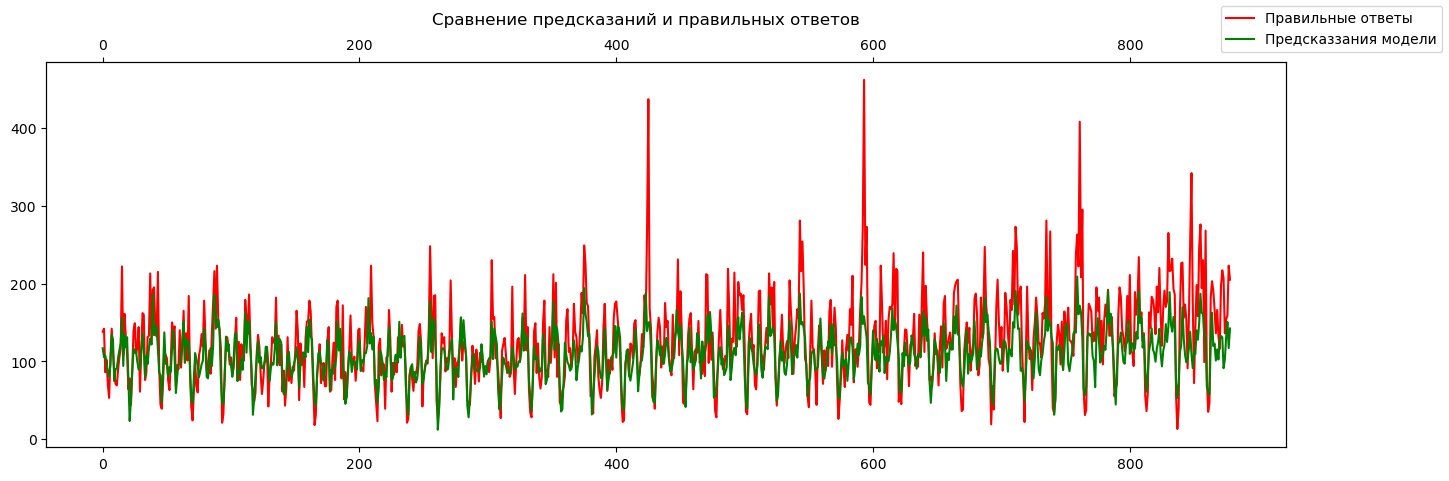

In [30]:
fig, ax1 = plt.subplots(figsize=(16, 5))
fig.suptitle('Сравнение предсказаний и правильных ответов')
ax1.plot(target_test.values, color='red')
ax2 = ax1.twiny()
ax2.plot(final_pred_cat, color='green')
fig.legend(['Правильные ответы', 'Предсказзания модели'])
fig.show()

По графику видно что в основном модель предсказывает правильно, количество ошибок незначительное.